# Quantum state tomography (QST) with a neural network written in Jax
### Using parity for measurements (Wigner function)

- Shahnawaz Ahmed (shahnawaz.ahmed95@gmail.com)

In this notebook we show a simple demonstration of using the custom `DensityMatrix`
and `Expectation` layer to build a neural network for QST that can take batches
of data and works for an arbitrary Hilbert space dimension.

#### Note 1:

This notebook requires using the automatic differentiation library Jax (https://github.com/google/jax) and the DeepMind neural network tools dm-haiku (https://github.com/deepmind/dm-haiku) and optax. You also need to install QuTiP (qutip.org).

The qutip installation requires Numpy, Scipy and Matplotlib for plotting. Install these first and then install QuTiP:

```
pip install numpy scipy matplotlib
pip install qutip
```

In future notebooks I will try to reduce the dependency to only Jax and QuTiP. You can install Jax and dm-haiku simply from pip as:

```
pip install jax jaxlib
pip install dm-haiku optax
```

I also use tqdm for nice progressbars

```
pip install tqdm
```
#### Note 2:

The latest Python (3.10) has some problems building Numpy wheels while installing QuTiP. I would suggest using Python 3.9 if you face such issues or installing Numpy 1.20. as that is the one supported by QuTiP as of (Dec 1, 2021). If you have a working QuTiP installation then everything should be fine.

## Imports

In [1]:
import numpy as np

import jax
import jax.numpy as jnp
from jax import jit

from jax.config import config
from jax.example_libraries import optimizers

import haiku as hk

import optax


from qutip import coherent, coherent_dm, hinton, expect, Qobj
from qutip import fidelity, plot_wigner

import matplotlib.pyplot as plt

config.update("jax_enable_x64", True) # We want float64 for better precision

from tqdm.auto import tqdm

# The state to be reconstructed (a CAT state)

Reconstructing the `cat` state from measurements of the Husimi Q function. The cat state is defined as:

$$|\psi_{\text{cat}} \rangle = \frac{1}{\mathcal N} ( |\alpha \rangle + |-\alpha \rangle \big ) $$

with $\alpha=2$ and normalization $\mathcal N$.

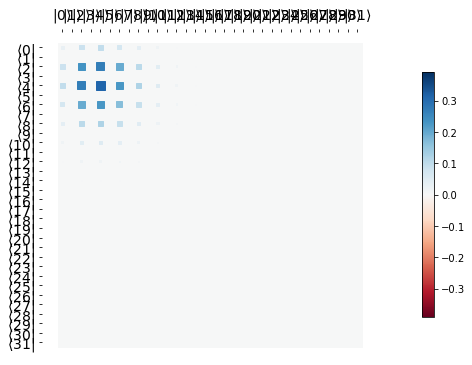

In [2]:
hilbert_size = 32
alpha = 2

psi = coherent(hilbert_size, alpha) + coherent(hilbert_size, -alpha)
psi = psi.unit() # The .unit() function normalizes the state to have unit trace

# Show the density matrix as a Hinton plot
rho_true = psi*psi.dag()

hinton(rho_true)
plt.show()

# The measurements performed on the state

We compute the operators that measure the Husimi Q function of the state. These
measurement operators can be replaced with any other operator for which we can
obtain experimental expectation values (e.g., Wigner functions, Pauli X, Y, Z for qubits etc.)

## Wigner function measurements

The Wigner function can be obtained by calculating the expectation value of
the following operator:

$$\mathcal \Pi(\beta) = \frac{2}{\pi}D(\beta)|n \rangle \langle n|D(-\beta)$$

where $D(\beta)$ is the displacement operator and $|n \rangle \langle n|$
represent Fock basis elements


### A fast implementation of displacement operator using JAX

See https://github.com/qgrad/qgrad/blob/master/qgrad/qgrad_qutip.py

In [3]:
def _kth_diag_indices(a, k):
    rows, cols = jnp.diag_indices_from(a)
    if k < 0:
        return rows[-k:], cols[:k]
    elif k > 0:
        return rows[:-k], cols[k:]
    else:
        return rows, cols


class Displace:
    r"""Displacement operator for optical phase space.
    
    .. math:: D(\alpha) = \exp(\alpha a^\dagger -\alpha^* a)
    Args:
    n (int): dimension of the displace operator
    """

    def __init__(self, n):
        # The off-diagonal of the real-symmetric similar matrix T.
        sym = (2.0 * (jnp.arange(1, n) % 2) - 1) * jnp.sqrt(jnp.arange(1, n))
        # Solve the eigensystem.
        mat = jnp.zeros((n, n), dtype=jnp.complex128)

        i, j = _kth_diag_indices(mat, -1)
        mat = mat.at[i, j].set(sym)

        i, j = _kth_diag_indices(mat, 1)
        mat = mat.at[i, j].set(sym)

        self.evals, self.evecs = jnp.linalg.eigh(mat)
        self.range = jnp.arange(n)
        self.t_scale = 1j ** (self.range % 2)

    def __call__(self, alpha):
        r"""Callable with ``alpha`` as the displacement parameter
        Args:
            alpha (float): Displacement parameter
        Returns:
            :obj:`jnp.ndarray`: Matrix representing :math:`n-`dimensional displace operator
            with :math:`\alpha` displacement
        
        """
        # Diagonal of the transformation matrix P, and apply to eigenvectors.
        transform = jnp.where(
            alpha == 0,
            self.t_scale,
            self.t_scale * (alpha / jnp.abs(alpha)) ** -self.range,
        )
        evecs = transform[:, None] * self.evecs
        # Get the exponentiated diagonal.
        diag = jnp.exp(1j * jnp.abs(alpha) * self.evals)
        return jnp.conj(evecs) @ (diag[:, None] * evecs.T)


def fock_dm(hilbert_size, n):
    """Generates Fock density matrices.

    Args:
        hilbert_size (int): Hilbet space dimension
        n (int): Fock number
    """
    mat = jnp.zeros((hilbert_size, hilbert_size), dtype=jnp.complex128)
    mat = mat.at[n, n].set(1.)
    return mat

In [5]:
displace = Displace(hilbert_size)

@jax.jit
def _wigner_op(beta: complex):
    """Computes the operator for a Wigner function measurement.

    Args:
        beta (complex): Phase space point
    """
    D = displace(beta)
    dagD = jnp.conj(D.T)
    op = sum([((-1)**i)*D@fock_dm(hilbert_size, i)@dagD for i in range(hilbert_size)])
    op = (op)*(2/np.pi)
    return op

# Vectorized Wigner op calculation
wigner_ops = jax.vmap(_wigner_op)

grid = 64

xvec = jnp.linspace(-3, 3, grid)
yvec = jnp.linspace(-3, 3, grid)

X, Y = jnp.meshgrid(xvec, yvec)

betas = (X + 1j*Y).ravel()
ops_jax = wigner_ops(betas)

In [6]:
m_ops = []

for op in tqdm(ops_jax):
    m_ops.append(Qobj(np.array(op)))

100%|██████████| 4096/4096 [00:01<00:00, 3127.39it/s]


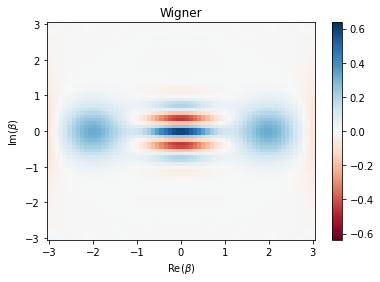

In [7]:
quasi_probabilities = expect(m_ops, psi)
cmap = "RdBu"
im = plt.pcolor(xvec, yvec, quasi_probabilities.reshape((grid, grid)),
                vmin=-2/np.pi, vmax=2/np.pi, cmap=cmap, shading='auto')

plt.colorbar(im)

plt.xlabel(r"Re($\beta$)")
plt.ylabel(r"Im($\beta$)")
plt.title("Wigner")
plt.show()

# Custom expectation function compiled with Jax

In [8]:
@jit # just in time compilation for speed
def expectation(rho, ops):
    """Expectation layer that predicts the expectation value for operators

    Args:
        rho (array): A density matrix as a Jax array of shape (N, N)
        ops (array): A set of measurement operators as a Jax array of shape
                     (n, N, N) where n is the number of operators

    Returns
        evals (array): An array of expectation values for the operators.
    """
    products = jnp.einsum('nij, jk -> nik', ops, rho)
    trace = jnp.einsum('nii -> n', products)
    return trace.real


ops_jax = jnp.array([op.full() for op in m_ops])
rho_jax = jnp.array(rho_true.full())
quasi_probabilities_jax = expectation(rho_jax, ops_jax)

np.testing.assert_array_almost_equal(quasi_probabilities, quasi_probabilities_jax)

# Custom Cholesky decomposition layer that coverts a random matrix to Hermitian

In [9]:
@jit
def clean_cholesky(chi):
    """Converts a random matrix which has a shape (N, N, 2) to a Hermitian
    matrix. The last dimension contains real and imaginary parts. 
    We consider a lower triangular complex matrix with real diagonals 
    and returning T'T.

    Args:
        chi (array): A matrix of shape (N, N, 2).

    Returns
        rho (array (complex)): A Hermitian matrix using the Cholesky decomposition
    """
    diagonal_elements = jnp.diag(jnp.diag(chi).real)
    indices = jnp.tril_indices(chi.shape[0], 0)
    # chi_upper = index_update(chi, index[indices], 0)
    chi_upper = chi.at[indices].set(0)
    T = chi_upper + diagonal_elements
    return jnp.conj(T.T)@T


rand_mat = np.random.random(size=(hilbert_size, hilbert_size)) + 1j*np.random.random(size=(hilbert_size, hilbert_size))
mat_cleaned = clean_cholesky(rand_mat)
print("Hermitian:", Qobj(np.array(mat_cleaned)).isherm)

Hermitian: True


# Data from sampling/adding Gaussian noise to the measured expectation values
# and taking a subset of the data

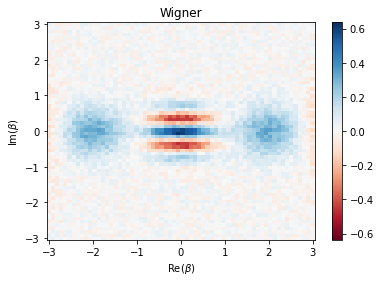

In [11]:
data = quasi_probabilities_jax + np.random.uniform(-0.05, 0.05, size=quasi_probabilities_jax.shape)

cmap = "RdBu"
im = plt.pcolor(xvec, yvec, data.reshape((grid, grid)),
                vmin=-2/np.pi, vmax=2/np.pi, cmap=cmap, shading='auto')

plt.colorbar(im)

plt.xlabel(r"Re($\beta$)")
plt.ylabel(r"Im($\beta$)")
plt.title("Wigner")
plt.show()

# A neural network that takes noisy data and operators and outputs expectations

The network keeps a latent representation of the quantum state as a Hermitian
matrix (density matrix) which we are after.

In [12]:
class Network(hk.Module):
    """Network model that goes from data -> rho."""
    def __init__(self, hilbert_size):
        super().__init__()
        self.hilbert_size = hilbert_size

    def __call__(self, x):
        x = hk.Flatten()(x)
        x = hk.Linear(64)(x)

        x = jax.nn.leaky_relu(x)
        x = hk.Linear(64)(x)
        x = jax.nn.leaky_relu(x)
        x = hk.Linear(64)(x)
        x = jax.nn.leaky_relu(x)
        x = x.reshape(1, -1)

        x = hk.Linear(self.hilbert_size**2 * 2)(x) # Real and complex parts
        x = x.reshape(self.hilbert_size, self.hilbert_size, 2)        
        x = x[..., 0] + 1j*x[..., 1]
        x = clean_cholesky(x)
        x = x/jnp.trace(x) # Trace preserving
        return x


rng_seq = hk.PRNGSequence(32)
model_forward = hk.transform(lambda x: Network(hilbert_size=hilbert_size)(x))
model_forward = hk.without_apply_rng(model_forward)

params = model_forward.init(next(rng_seq), data)
# If you want to send data in batches this can be 
# data[:batch_size, :batch_size].real


# Writing a loss function

In [13]:
@jit
def loss_fn(params, d, ops):
    """Loss function to optimize.

    Args:
        params ([type]): Neural network parameters
        d ([type]): Data
        ops ([type]): Operators measured

    Returns:
        float: The loss value.
    """
    rho_predicted = model_forward.apply(params, d)
    data_predicted = expectation(rho_predicted, ops)
    loss = jnp.sum((d - data_predicted)**2)
    return loss + 0.001*jnp.sum(jnp.abs(rho_predicted))


print(loss_fn(params, data, ops_jax))

41.08705342027047


# Optimization with Adam

Feel free to change the hyperparameters such as the learning rate. Also the number
of optimization steps

In [14]:
optimizer = optax.adam(2e-2, 0.9, 0.9)
opt_state = optimizer.init(params)

@jax.jit
def update(
    params,
    opt_state,
    d, ops):
    """Single SGD update step."""
    grads = jax.grad(loss_fn)(params, d, ops)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state


loss_hist = []

In [17]:
for step in tqdm(range(100)):
    params, opt_state = update(params, opt_state, data, ops_jax)
    loss_hist.append(loss_fn(params, data, ops_jax))


100%|██████████| 100/100 [00:12<00:00,  7.89it/s]


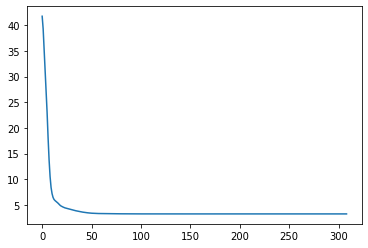

In [18]:
plt.plot(loss_hist)

In [19]:
rho_predicted = model_forward.apply(params, data)
data_predicted = expectation(rho_predicted, ops_jax)
rho_predicted = Qobj(np.array(rho_predicted))

# Predicting the reconstruted data and the state

With more noise in the Q function, the network predicts a different CAT!!

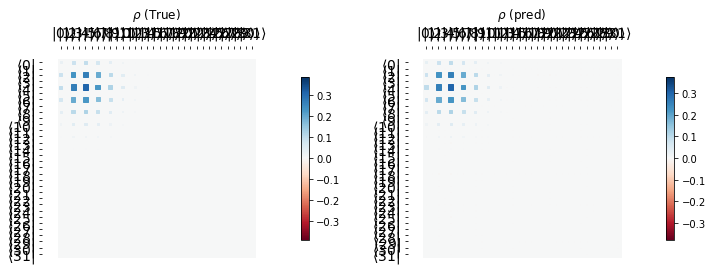

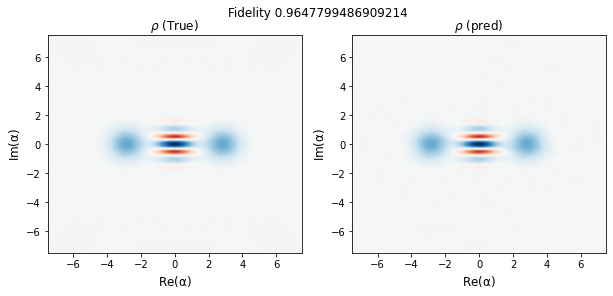

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

hinton(rho_true, ax=ax[0])
hinton(rho_predicted, ax=ax[1])

ax[0].set_title(r"$\rho$ (True)")
ax[1].set_title(r"$\rho$ (pred)")
plt.show()


fig, ax = plt.subplots(1, 2, figsize=(10, 4))

plot_wigner(rho_true, ax=ax[0])
plot_wigner(rho_predicted, ax=ax[1])

ax[0].set_title(r"$\rho$ (True)")
ax[1].set_title(r"$\rho$ (pred)")

plt.suptitle(f"Fidelity {fidelity(rho_true, rho_predicted)**2}")
plt.show()

# The data vs prediction

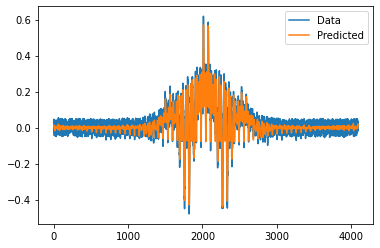

In [24]:
plt.plot(data, label="Data")
plt.plot(data_predicted, label="Predicted")
plt.legend()
plt.show()